# GermEval-2020 German Motivational Style Detection Dataset

Obtained from https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/germeval-2020-cognitive-motive.html via [this link](https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/germeval-2020-cognitive-motive/public-data.zip)

```
@article{johannssengermeval,
  title={GermEval 2020 Task 1 on the Classification and Regression of Cognitive and Motivational Style from Text: Companion Paper},
  author={Johann{\ss}en, Dirk and Biemann, Chris and Remus, Steffen and Baumann, Timo and Scheffer, David}
}
```

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import hashlib

TRAIN_DATASET_LOCATION = "../datasets/germeval2020/public-data/train_data_sets/psychopred_task2_train_texts.tsv"
TRAIN_LABELS_LOCATION = "../datasets/germeval2020/public-data/train_data_sets/psychopred_task2_train_labels.tsv"
TEST_DATASET_LOCATION = "../datasets/germeval2020/public-data/test_data_sets/psychopred_task2_test_texts.tsv"
TEST_LABELS_LOCATION = "../datasets/germeval2020/public-data/test_data_sets/psychopred_task2_test_labels.tsv"

### Validity check

In [2]:
VERIFY_CHECKSUM = True

In [3]:
assert os.path.exists(TRAIN_DATASET_LOCATION)
assert os.path.exists(TEST_DATASET_LOCATION)
assert os.path.exists(TRAIN_LABELS_LOCATION)
assert os.path.exists(TEST_LABELS_LOCATION)

def verify_checksum(file, checksum):
    with open(file, "rb") as f:
        file_hash = hashlib.md5()
        while chunk := f.read(8192):
            file_hash.update(chunk)
    assert checksum == file_hash.hexdigest()
    print("Checksum matches")
    
if VERIFY_CHECKSUM:
    verify_checksum(TRAIN_DATASET_LOCATION, 'a170030e566210e4925a06dd573bd15a')
    verify_checksum(TEST_DATASET_LOCATION, 'bfaef21744d2e35ef4f9ff90f0feb4ac')
    verify_checksum(TRAIN_LABELS_LOCATION, 'c4fbbce6a1bbf2ca81a457a121ed02c2')
    verify_checksum(TEST_LABELS_LOCATION, '40943b24e22e667998f3e4fe70674ca8')

Checksum matches
Checksum matches
Checksum matches
Checksum matches


### Read data
Please note that the training set contains some illegal entries with motive '\\N'

In [4]:
def read_germeval_2020(text_location, label_location, nrows=None):
    df = pd.read_csv(text_location, nrows=nrows, sep="\t", escapechar="\\").merge(pd.read_csv(label_location, nrows=nrows, sep="\t", escapechar="\\"), on='UUID')
    df['target'] = df.motive
    #df['target'] = df.motive.str.cat(df.level.map(str), sep='-')
    df = df.rename(columns={'OMT_text':'text'})
    df = df[df.target != '\\N']
    return df[['text', 'target']]

read_germeval_2020(TRAIN_DATASET_LOCATION, TRAIN_LABELS_LOCATION, nrows=10)

,text,target
0,ignorieren des Getuschels.angespannt.geht es s...,F
1,"Nähe, umarmen.gut, wertgeschätzt.weil sie der ...",M
2,seine Stärke zeigen.stark.weil sie stark ist.,F
3,Sie flüstern. Sie wollen Ihrer Wut Luft machen...,M
4,"sie hat eine Aufgabe erfolgreich bewältigt, de...",F
5,"Sie ist führend, dominierend.überlegen.Weil si...",M
6,der eine sagt dem anderen die Lösung vor.versc...,A
7,"sie versucht ihre freunde zu überzeugen, sie h...",M
8,die personen reparieren etwas am fließband. si...,M
9,sich bejubeln zu lassen.stolz.weil sie bejubel...,F


In [5]:
df_train = read_germeval_2020(TRAIN_DATASET_LOCATION, TRAIN_LABELS_LOCATION)
df_train.shape # 167200 with '\\N' entries

(167187, 2)

In [6]:
df_train.head()

,text,target
0,ignorieren des Getuschels.angespannt.geht es s...,F
1,"Nähe, umarmen.gut, wertgeschätzt.weil sie der ...",M
2,seine Stärke zeigen.stark.weil sie stark ist.,F
3,Sie flüstern. Sie wollen Ihrer Wut Luft machen...,M
4,"sie hat eine Aufgabe erfolgreich bewältigt, de...",F


Text(0.5, 0, 'Count')

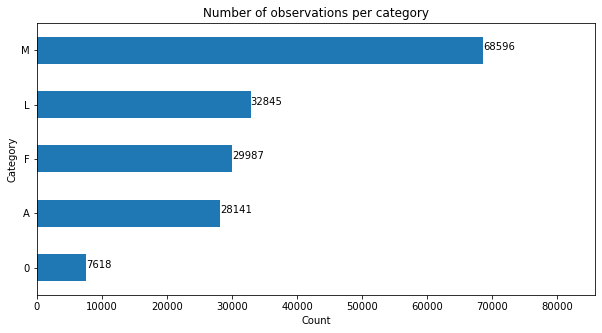

In [7]:
vc = df_train.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export file

In [8]:
PREPROCESSED_FILE = '../datasets/preprocessed/germeval2020_train.csv'
df_train.to_csv(PREPROCESSED_FILE, index=False)

### Detect Non-German texts

In [9]:
import fasttext
import numpy as np
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

LANGUAGE_DETECTION_MODEL = "../fasttext/language_identification/lid.176.bin" #https://fasttext.cc/docs/en/language-identification.html
model = fasttext.load_model(LANGUAGE_DETECTION_MODEL)

In [10]:
def get_language(paragraph, k=None, return_all=False, min_certainty=0.25):
    if pd.isna(paragraph):
        return np.nan
    sentences = [line for line in paragraph.split("\n") if line != '']
    if len(sentences) < 1:
        return np.nan
    class_labels, certainties = model.predict(sentences, k)
    # sum certainties per class label and then divide by length -> avg certainty
    class_lookup, indexed_lang = np.unique(np.hstack(class_labels), return_inverse=True)
    summed_certainties = np.bincount(indexed_lang, weights=np.hstack(certainties))/len(sentences)
    if return_all:
        return dict(zip(class_lookup, summed_certainties))
    
    # get most likely lang
    lang_id = np.argmax(summed_certainties)
    if summed_certainties[lang_id] < min_certainty:
        return np.nan
    return class_lookup[lang_id]        

In [11]:
df_train['lang'] = df_train.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/167187 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

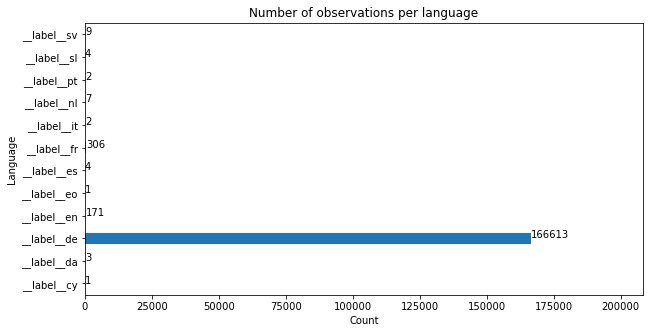

In [12]:
vc = df_train.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [13]:
vc.nlargest(5)

__label__de    166613
__label__fr       306
__label__en       171
__label__sv         9
__label__nl         7
Name: lang, dtype: int64

In [14]:
f"{vc['__label__de']/df_train.shape[0]*100:.4f}% of samples are german" 

'99.6567% of samples are german'

### Test Set analysis

In [15]:
df_test = read_germeval_2020(TEST_DATASET_LOCATION, TEST_LABELS_LOCATION)

In [16]:
df_test.head()

,text,target
0,"sie wollen, dass sich die andere person ihnen ...",0
1,Schadensbegrenzung durch Rechtfertigung. Schle...,F
2,Ausgeglichenheit und Ruhe. Ein Geständnis anhö...,M
3,Es ist im egal was die anderen über ihn sprech...,F
4,Die Person ist dabei einen Berg zu besteigen u...,L


Text(0.5, 0, 'Count')

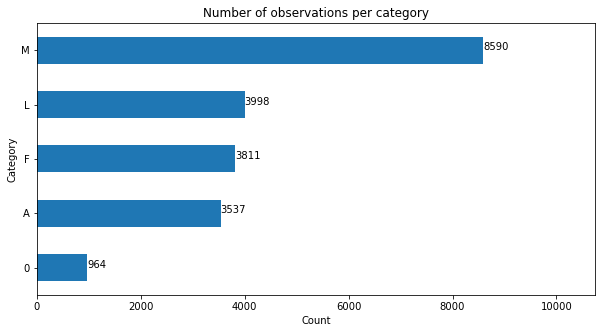

In [17]:
vc = df_test.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export file

In [18]:
PREPROCESSED_FILE = '../datasets/preprocessed/germeval2020_test.csv'
df_test.to_csv(PREPROCESSED_FILE, index=False)

In [19]:
df_test['lang'] = df_test.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/20900 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

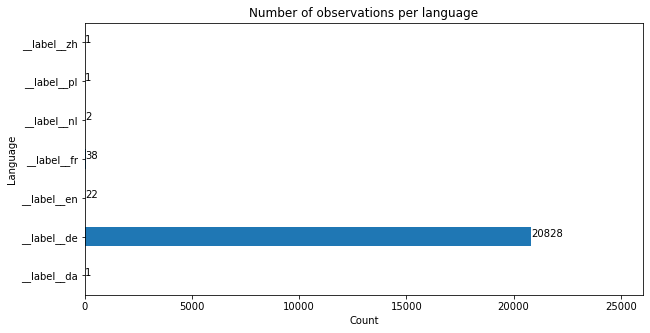

In [20]:
vc = df_test.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [21]:
vc.nlargest(5)

__label__de    20828
__label__fr       38
__label__en       22
__label__nl        2
__label__da        1
Name: lang, dtype: int64

In [22]:
f"{vc['__label__de']/df_test.shape[0]*100:.4f}% of samples are german" 

'99.6555% of samples are german'